## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

# 1.Camera Calibration

### Imports

In [2]:
#import all the required dependancies
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import ipywidgets as widgets
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Find and analyse the chessboard calibration images

In [3]:
#the number of inner square corners in the x and y axes
nx = 9
ny = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('/home/da7th/Desktop/Udacity/sdc/CarND-P4/CarND-Advanced-Lane-Lines-master/camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

#close any window opened for preview
cv2.destroyAllWindows()

#### The openCV function:
    cv2.findChessboardCorners(gray, (9,6),None)
#### was used to find the chessboard's inner corners where 6 and 9 are the horizontal and vertical inner corners of the image provided. After obtaining the object and image points in the image the chessboard can be drawn using:
    cv2.drawChessboardCorners(img, (9,6), corners, ret)

### calibrate the actual camera

In [4]:
#perform the calibration after getting the obj and img points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#### Finally all the required inputs are available to calibrate the camera using:
    cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Define the function the will warp the image using the calibration's output params

In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #if ret == True:
    # If we found corners, draw them! (just for fun)
    cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                 [img_size[0]-offset, img_size[1]-offset], 
                                 [offset, img_size[1]-offset]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M

#### Now that the camera calibration vectors are available to undistort any images taken by this camera using:
    undist = cv2.undistort(img, mtx, dist, None, mtx)

#### To undistort and transform an image, we first need to define the source coordinates and the destination coordinates they should be mapped to (src and dst), after which we use the function:
    M = cv2.getPerspectiveTransform(src, dst)
#### To get the perspective transform matrix used in the following perspective transofrm function:
    warped = cv2.warpPerspective(undist, M, img_size)
    
#### The following is an example of an image that was used for calibration, as well as it's drawChessboard, Undistort, and PersectiveTransform outputs:

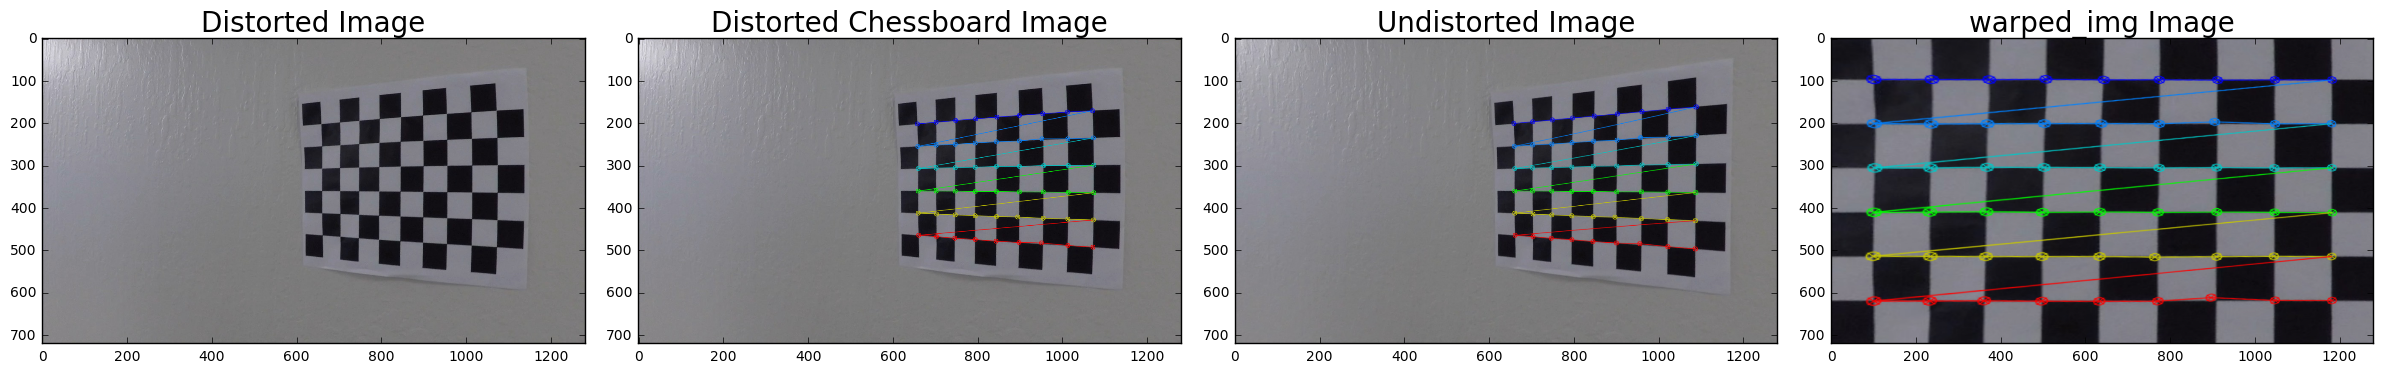

In [6]:
#output an undistorted and transformed image
img = mpimg.imread(images[5])
# Convert undistorted image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Search for corners in the grayscaled image
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
# If we found corners, draw them! (just for fun)
dist_drawn = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
undist = cv2.undistort(img, mtx, dist, None, mtx)
# warped (transformed image)
warped_img, M = corners_unwarp(mpimg.imread(images[5]), nx, ny, mtx, dist )
distorted = mpimg.imread(images[5])

#plot outputs
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(distorted)
ax1.set_title('Distorted Image', fontsize=20)
ax2.imshow(dist_drawn)
ax2.set_title('Distorted Chessboard Image', fontsize=20)
ax3.imshow(undist)
ax3.set_title('Undistorted Image', fontsize=20)
ax4.imshow(warped_img)
ax4.set_title('warped_img Image', fontsize=20)

# 2.Distortion Correction

#### The following is an undistort-image function based on the above calibration

In [7]:
#undistort image function
def undistort_img(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# 3.Color/Gradient Threshold

### Gradient thresholds

In [8]:
#load an image
img = mpimg.imread('/home/da7th/Desktop/Udacity/sdc/CarND-P4/CarND-Advanced-Lane-Lines-master/test_images/test5.jpg')

### The following function is the gradient pipeline. 
#### In this pipeline we define fixed values based on the experimentation in the accompanying file image_experimentation. The process here is that after we convert the image to grayscale using:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#### We can place thresholds on the image to make the edges more pronouced and easier to manipulate later on. To help with this we can use the Sobel operator function from the openCV library. The sobel operator is an edge detection technique and the function is as follows:
    cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=dir_k)
#### The scaled binary X and Y threshold is the absolute of the Sobel opertor in either the X or Y directions. While the magnitude threshold is simply the magnitude of the two absolutes. We scale these values by dividing their 255 multiple with the maximum value in the image like:
    scaled_sobelx = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
#### This ofcourse will then be thresholded based on the experimental values entered to obtain the final thresholded image. This process is done for X-scaled, Y-scaled and Magnitude scaled as follows:
    mag_binary[(scaled_sobel >= mag_thresh_min) & (scaled_sobel <= mag_thresh_max)] = 1
#### The final gradient threshold is the directional threshold achieved by obtaining the arctan values for the X and Y absolutes, before again thresholding the output.:
    gradient_direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    
#### The output of the following pipeline is a combination of the 4 thresholding outputs performed on the image

In [9]:
#pipeline for the full gradient combinations
def grad_pipeline(img):
    #fixed values
    dir_k = 17
    dir_thresh_min = 0.4
    dir_thresh_max = 1.3
    mag_thresh_min = 45
    mag_thresh_max = 130
    thresh_min_x = 30
    thresh_max_x = 130
    thresh_min_y = 30
    thresh_max_y = 130
    
    #grayscale of the image 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #absolutes
    abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=dir_k))
    abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=dir_k))
    abs_sobel_xy = np.sqrt((np.square(abs_sobel_x))+(np.square(abs_sobel_y)))
    
    #obtain x and y thresholds
    scaled_sobelx = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    scaled_sobely = np.uint8(255*abs_sobel_y/np.max(abs_sobel_y))
    binary_outputx = np.zeros_like(scaled_sobelx)
    binary_outputx[(scaled_sobelx >= thresh_min_x) & (scaled_sobelx <= thresh_max_x)] = 1
    binary_outputy = np.zeros_like(scaled_sobely)
    binary_outputy[(scaled_sobely >= thresh_min_y) & (scaled_sobely <= thresh_max_y)] = 1
    
    #obtain the magnitude threshold
    scaled_sobel = np.uint8(255*abs_sobel_xy/np.max(abs_sobel_xy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh_min) & (scaled_sobel <= mag_thresh_max)] = 1
    
    #obtain the directional threshold
    gradient_direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    dir_binary = np.zeros_like(gradient_direction)
    dir_binary[(gradient_direction >= dir_thresh_min) & (gradient_direction <= dir_thresh_max)] = 1
    
    #combine the grad_thresholds
    combined = np.zeros_like(dir_binary)
    combined[((binary_outputx == 1) & (binary_outputy == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

#### Here is a sample output of a road image and the corresponding pipeline output

In [10]:
#plot outputs
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Sample Image', fontsize=20)
ax2.imshow(grad_pipeline(img), cmap = 'gray')
ax2.set_title('Gradient Pipeline Sample', fontsize=20)

### Colour thresholds

#### The following is the Colour threshold pipeline. First of all, the image is originally loaded in RGB format where we can straight away seperate the Red channel since it proved to be the best one at picking out lane lines of different bright colours. This R channel is then thresholded like the gradient thresholds above to enhance our lane detections further. Here is how to split the R channel of the input image:
    R = img[:,:,0]
#### The next step in the colour pipeline is to convert the image into HLS colour space using the function:
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#### Based on experimentation both the L and S channels will be thresholded and obtain them as follows:
    L = hls[:,:,1]
    S = hls[:,:,2]
#### The Lightness channels has the added functionality of helping to overcome the brightness in the image. As with the gradient thresholds we obtain the absolute of the Soble operator outputs and combine all three thresholds as follows:
    combined[((binary_R == 1) & (L_s_binary == 1)) | ((S_binary == 1))] = 1 
#### The output of the following pipeline is a combination of the 3 thresholding outputs performed on the image

In [11]:
#colour channel thresholding pipeline
def col_pipeline(img):
    #fixed values
    R_thresh_min = 200
    R_thresh_max = 255
    S_thresh_min = 170
    S_thresh_max = 255
    L_thresh_min = 20
    L_thresh_max = 100
    
    #get the R channel threshold
    R = img[:,:,0]
    binary_R = np.zeros_like(R)
    binary_R[(R > R_thresh_min) & (R <= R_thresh_max)] = 1
    
    #get the S and L channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    L_sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0) # Take the derivative in x
    L_abs_sobelx = np.absolute(L_sobelx) # Absolute x derivative to accentuate lines away from horizontal
    L_scaled_sobel = np.uint8(255*L_abs_sobelx/np.max(L_abs_sobelx))
    
    # Threshold x gradient
    L_s_binary = np.zeros_like(L_scaled_sobel)
    L_s_binary[(L_scaled_sobel >= L_thresh_min) & (L_scaled_sobel <= L_thresh_max)] = 1
    
    # Threshold color channel
    S_binary = np.zeros_like(S)
    S_binary[(S >= S_thresh_min) & (S <= S_thresh_max)] = 1

    #combine the thresholds
    combined = np.zeros_like(binary_R)
    combined[((binary_R == 1) & (L_s_binary == 1)) | ((S_binary == 1))] = 1
    color_binary = combined
    
    return color_binary

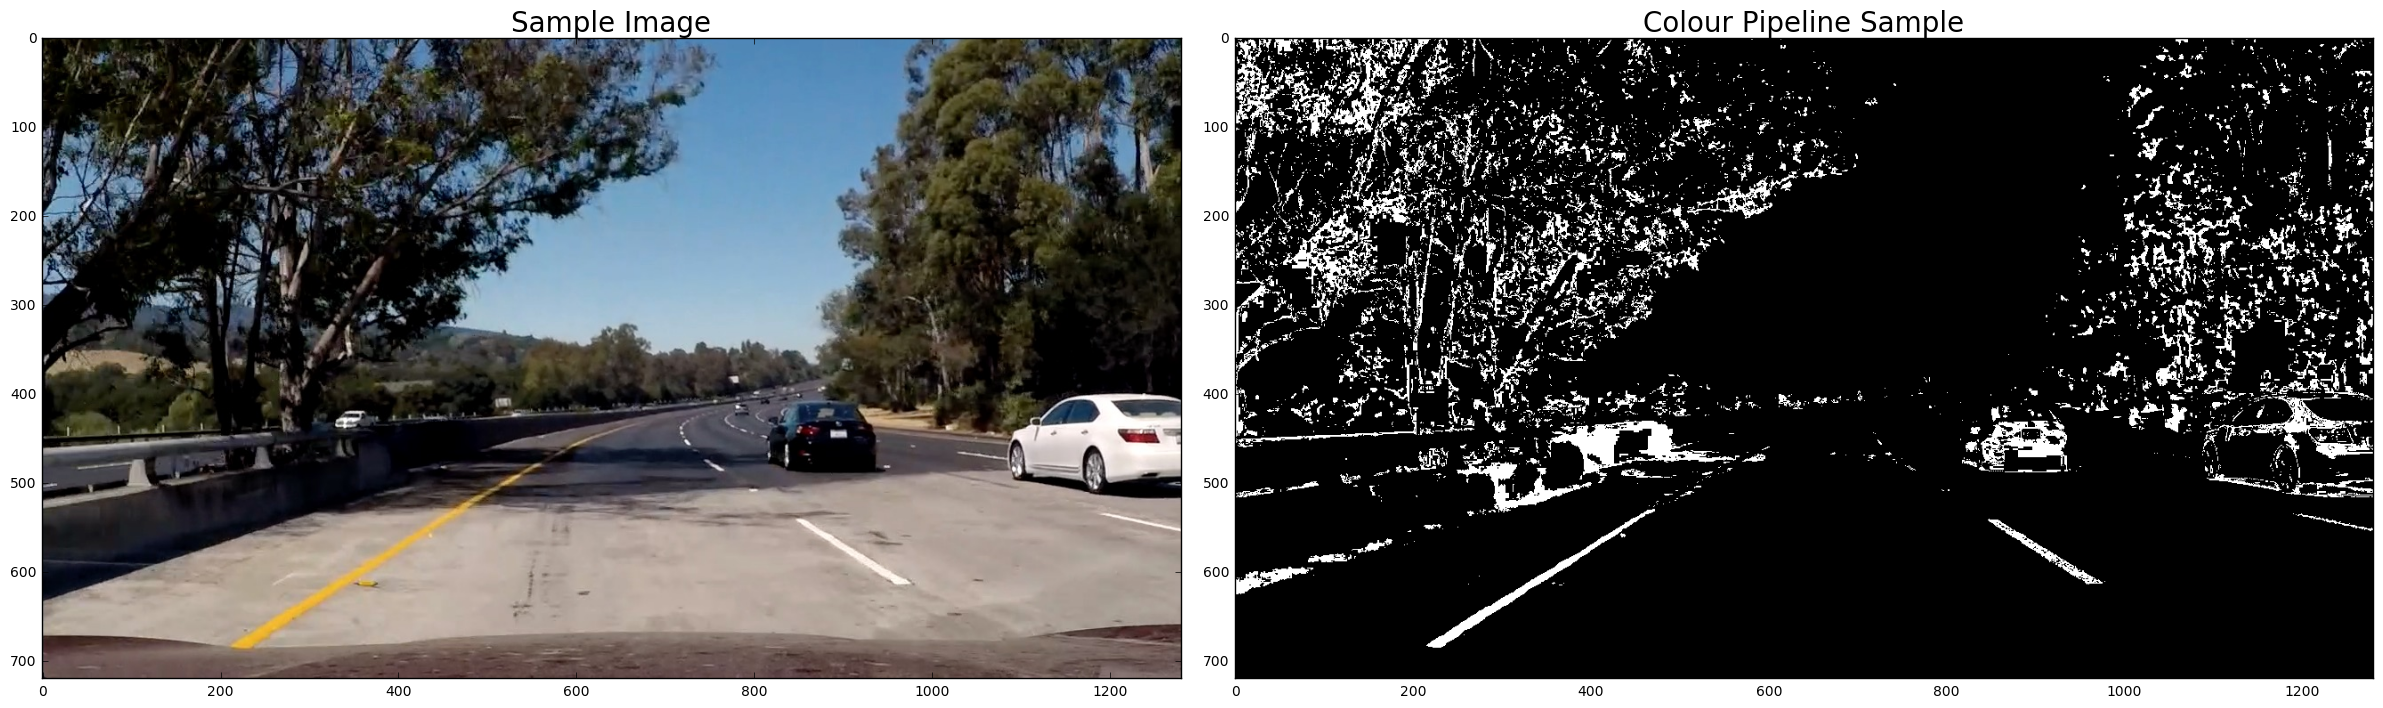

In [12]:
#plot outputs
f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Sample Image', fontsize=20)
ax2.imshow(col_pipeline(img), cmap = 'gray')
ax2.set_title('Colour Pipeline Sample', fontsize=20)

#### Since we will be performing both pipelines on every image the following function is simply a combination of the pipeline outputs

In [13]:
# a function that calls and combines the thresholding pipelines
def get_lanes(img):
    #combine the grad and color thresholds
    combined = np.zeros_like(img[:,:,2])
    combined[((col_pipeline(img) == 1) | (grad_pipeline(img) == 1))] = 1
    
    return combined

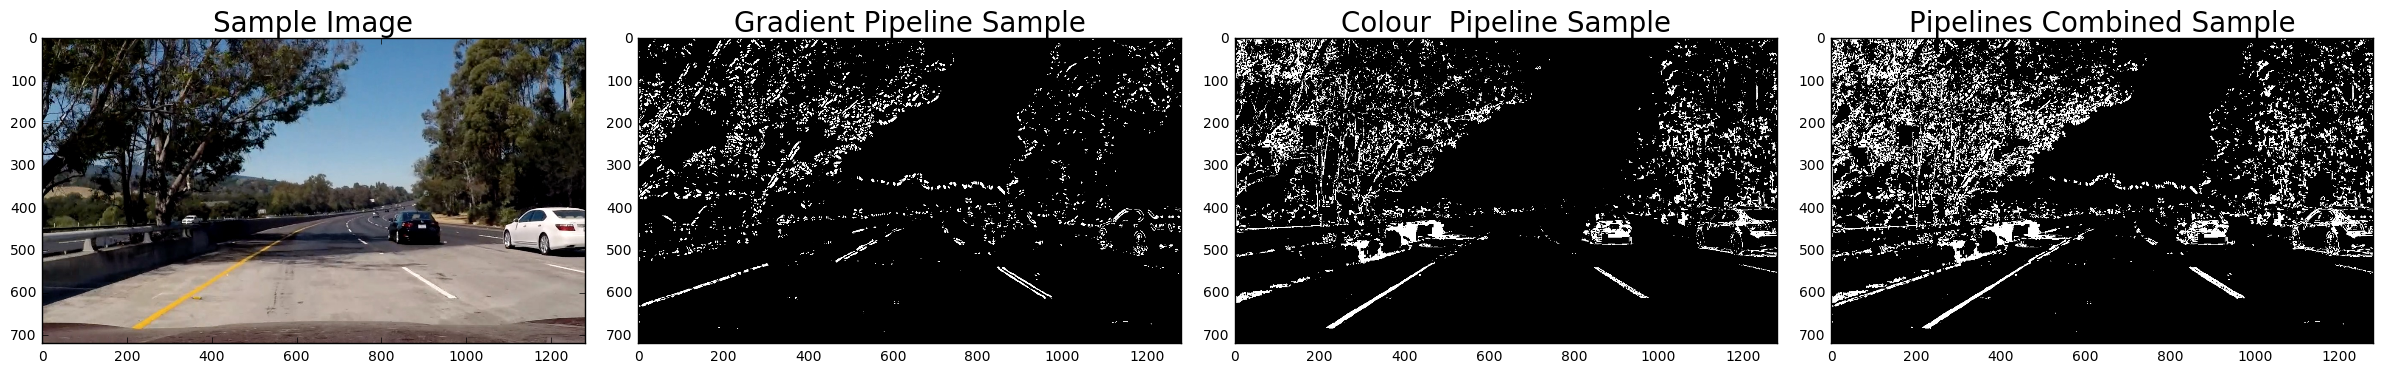

In [14]:
#plot outputs
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Sample Image', fontsize=20)
ax2.imshow(grad_pipeline(img), cmap = 'gray')
ax2.set_title('Gradient Pipeline Sample', fontsize=20)
ax3.imshow(col_pipeline(img), cmap = 'gray')
ax3.set_title('Colour  Pipeline Sample', fontsize=20)
ax4.imshow(get_lanes(img), cmap = 'gray')
ax4.set_title('Pipelines Combined Sample', fontsize=20)

# 4.Perspective Transform

### Transform Image to a top-down perspective

#### In order to detect the lines and their curvature it is very helpful to transform the area covering the desired area to square or rectangular form that can show the parallel state of the lane lines and their curves more clearly. To do so we first need to identify the original coordinates and the coordinates they should be transformed to fit instead. This was already achieved in the experimentation file and the coordinates have been fixed below. Since the size of the input isn't always fixed the actual coordinates are fixed in a ratio form based on the test images used as follows:
    np.float32([[img.shape[1]*(src1x/1280),img.shape[0]*(src1y/720)],
                 [mg.shape[1]*(src2x/1280),img.shape[0]*(src2y/720)],
                 [img.shape[1]*(src3x/1280),img.shape[0]*(src3y/720)],
                 [img.shape[1]*(src4x/1280),img.shape[0]*(src4y/720)]])
#### The transformation function used is:
    cv2.getPerspectiveTransform(src, dst)
#### This function provides us with the transformation matrix, the same used in the calibration example above. Here however we also obtain the inverse transformation matrix, as later after we obtain the required information we'll need to return the image back to it's original form. We obtain the inverse matrix by simply reversing the source and destination arrays like:
    cv2.getPerspectiveTransform(dst, src)
#### Finally we warp the input image to obtain the lane lines using:
    cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
#### The following function is the perspective transform function to be used later

In [15]:
#function to transform the perpective of the image
def persp_trans(img):
    #fixed values based on experimentation
    src1x=0
    src2x=1280
    src3x=754
    src4x=526
    src1y=720
    src2y=720
    src3y=470
    src4y=470
    dst1x=0
    dst2x=1280
    dst3x=1280
    dst4x=0
    dst1y=720
    dst2y=720
    dst3y=0
    dst4y=0
    #get the input image size (since this may vary between runs)
    img_size = (img.shape[1], img.shape[0])

    #obtain and set the source points based on the given ratios
    src = np.float32([[img.shape[1]*(src1x/1280),img.shape[0]*(src1y/720)],
                      [img.shape[1]*(src2x/1280),img.shape[0]*(src2y/720)],
                      [img.shape[1]*(src3x/1280),img.shape[0]*(src3y/720)],
                      [img.shape[1]*(src4x/1280),img.shape[0]*(src4y/720)]])
    
    #obtain and set the destination points based on the given ratios
    dst = np.float32([[img.shape[1]*(dst1x/1280),img.shape[0]*(dst1y/720)],
                      [img.shape[1]*(dst2x/1280),img.shape[0]*(dst2y/720)],
                      [img.shape[1]*(dst3x/1280),img.shape[0]*(dst3y/720)],
                      [img.shape[1]*(dst4x/1280),img.shape[0]*(dst4y/720)]])
    
    #obtain the transormation matrix from source to destination
    M = cv2.getPerspectiveTransform(src, dst)
    #obtain the inverse of the matrix to undo the transformation after curvature is obtained
    Minv = cv2.getPerspectiveTransform(dst, src)
    #warp the input image to the destination coordinates
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

#### The following images are sample of the transformation on a normal image and a thresholded image

In [16]:
#load an image
img = mpimg.imread('/home/da7th/Desktop/Udacity/sdc/CarND-P4/CarND-Advanced-Lane-Lines-master/test_images/test5.jpg')

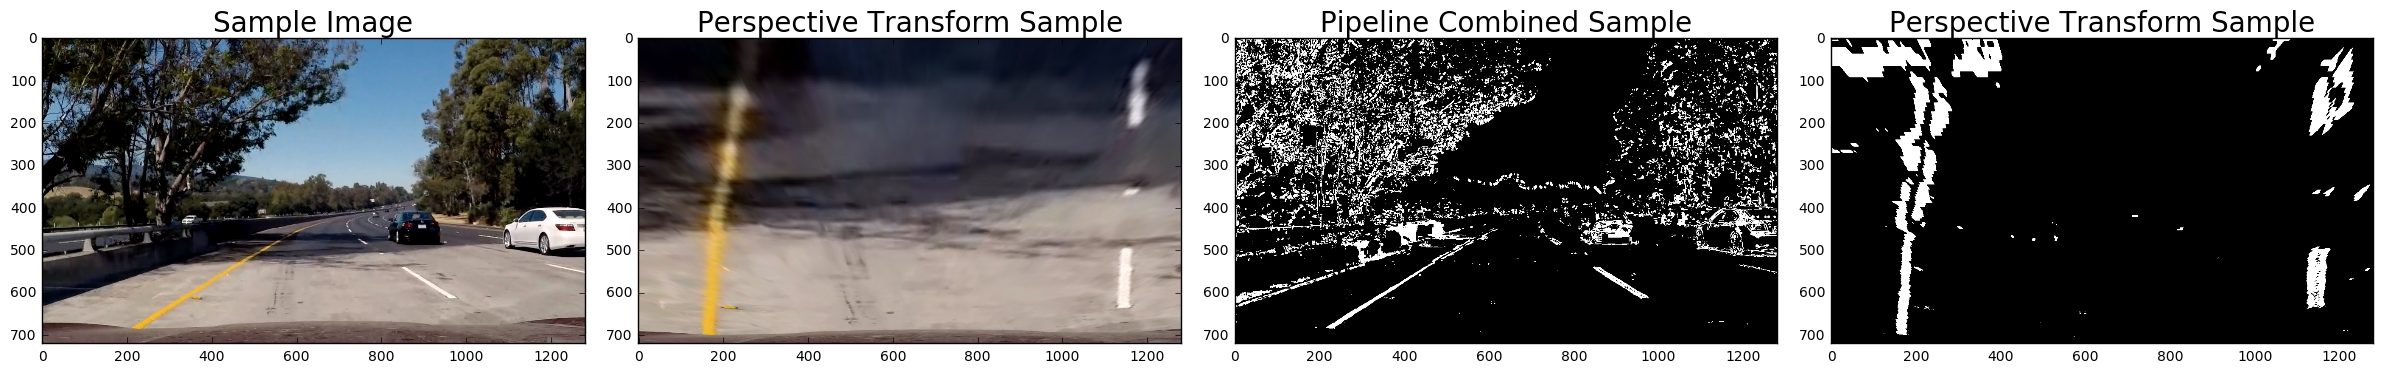

In [17]:
#plot outputs
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Sample Image', fontsize=20)
ax2.imshow(persp_trans(img)[0])
ax2.set_title('Perspective Transform Sample', fontsize=20)
ax3.imshow(get_lanes(img), cmap = 'gray')
ax3.set_title('Pipeline Combined Sample', fontsize=20)
ax4.imshow(persp_trans(get_lanes(img))[0], cmap = 'gray')
ax4.set_title('Perspective Transform Sample', fontsize=20)

# 5.Detect Lane Lines

### Find the Left and Right lanes in a transformed image

#### The next step in the project is finally detect the actual lanes of the road from our transformed image. The way to start this to obtain a histogram of the white pixels over the X-axis of the image where we expect to find clear spikes or peaks where the lanes start, like this:
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
#### Based on the mid point of the image and peaks of the histogram we identify the base points of the lane as follows:
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#### We also note down the middle of the lane to be:
    (rightx_base + leftx_base)/2
#### We define the number of windows the we want to cover each lane line vertically and divide the image pixel height accordingly. Next we go over each window for both axes - if the draw_windows variable is positive, draw the windows in the output - identifying the amount of non-zero pixels. We append the all the positive indices as "good indeces" for either lane line. After the windows are scanned we check if the good indeces satisfy the minimum number of pixels, and if so, obtain the non-zero mean and append it as a current variable to use in recentering the next window.
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#### Once we're done with all the windows and are done concatenating the left and right outputs in sperate arrays, we fit a second order polynomial over each one using:
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
#### this will help us calculate the curvature of the road in the image. We can finally plot the fitted lines and colour in the lane pixels to introduce more visual clarity using:
   ##### For the line fitting:
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   ##### For the lane colouring:
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#### Finally we output all the variables obtained and calculated in the function


In [18]:
#Global value placeholders
r_pre = []
l_pre = []
l_inds_pre = []
r_inds_pre = []
counter_chk = 0
#function to detect the lane lines, draw them, obtain the fitted lines points
def lanes_and_curv(warped, draw_squares=False):
    global r_pre
    global l_pre
    global counter_chk
    global l_inds_pre
    global r_inds_pre
    
    counter_reset = 24
    # Take a histogram of the bottom half of the image
    binary_warped = warped
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # this mid point will also help identify the car's position within the lanes by comparing the midpoint with
    # the image's midpoint
    midpoint = np.int(histogram.shape[0]/2)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting points for the left and right lines
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #this is to check that the lanes are at least a certain amount apart by whichever lane is more likely correct
    #based on general lane to image proportions
    if (rightx_base - leftx_base) < midpoint:
        if leftx_base > ((histogram.shape[0])/3):
            leftx_base = int(rightx_base - midpoint*1.35)
        else:     
            rightx_base = int(leftx_base + midpoint*1.35)
    # middle of the lane at the base line
    mid_lanes = (rightx_base + leftx_base)/2
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    maxpix = 300
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_squares == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #smooth the results
    if np.array_equal(l_pre,[]):
        l_pre = left_fit
        r_pre = right_fit
    else:
        l_holder = []
        r_holder = []
        for i in range(len(left_fit)):
            left_fiti = left_fit[i]*0.9+l_pre[i]*0.1
            right_fiti = right_fit[i]*0.9+r_pre[i]*0.1
            l_holder.append(left_fiti)
            r_holder.append(right_fiti)
            
        left_fit = l_holder
        right_fit = r_holder
        l_pre = left_fit
        r_pre = right_fit
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [99, 42, 42]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [219, 104, 255]
    
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, warped, mid_lanes


#### The following is a sample image ouput for the above function

In [19]:
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, warped, mid_lanes = lanes_and_curv(persp_trans(get_lanes(img))[0], True)
plt.imshow(out_img)
mark_size = 3
plt.plot(left_fitx, ploty, 'x', color='yellow', markersize=mark_size)
plt.plot(right_fitx, ploty, 'x', color='yellow', markersize=mark_size)

# 6.Determine Lane Curvature

### Next up we should determine the road curvature

#### the following function is used to obtain the curvature of the road up ahead in meters. First we use the following formula utilising the max y-plot value obtained before to calculate the curvature for each lane respectively in terms of pixels:
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#### Based on experimentation values we create a conversion ratio taking into account the ratio of experimentation image size to the actual image size used later for both the X and Y axes. The converted values can now again be fitted with a second order polynomial to identify the curvature of the lane lines (left and right) but in meter values:
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#### Finally this function will return the real curvature values for the left and right lanes

In [20]:
def real_curv(out_img, left_fitx, right_fitx, ploty, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad

# real_curv(out_img, left_fitx, right_fitx, ploty, left_fit, right_fit)

### Draw the lanes for visual reference

#### To have a visual reference to the performance of the pipeline (or just for an awesome looking output!) we need to use the openCV function:
    cv2.fillPoly()
#### To use this function however we should return our y-plot and fit-lines to a format that can be used by the function - slightly different for the left and right lanes as we want to cover the area in between them - we do this with the following:
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
#### This will return a stack of arrays which we'll input to the openCV fill polynomial function:
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 203, 255))
#### After we apply the lane shading we'd like to see this change in a normal camera view which is where our inverse matrix transform value comes in handy, and we transform our new image to its original perspective with:
    cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
#### And this then combined with the original image before outputing with the function:
    cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [21]:
def draw_curv(img, warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts[:,:,:]]), (0, 203, 255))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 0.8, newwarp, 0.8, 0)
    
    return result
# result = draw_curv(img, warped, left_fitx, right_fitx, ploty, Minv)

# Complete Pipeline

### Now merge everything together

#### This is a small function to help layer the lanes over the input images of the video

In [22]:
#layer together two input images
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

#### The following function merges all the previous functions together so that it can be applied to video frames easily. The steps are as follows:
* obtain warp information and a warped image
* find and obtain the lane lines and their corresponding points
* compute the pixel difference and apply it in finding the drift in meters
* draw the curves
* return to the original perspective
* layer the drawings over the original image
* print on the image the average curvature value and the drift

#### a couple of additions include the 48 runs check to smooth the readings as they tend fluctuate heavily and the check for whether the drift is to the left or to the right

In [23]:
#placeholder values
LC = 90
counter = 0
runs = []
print_curv = 0
#function used to process an image
def process_img(img):
    global LC
    global runs
    global counter
    global print_curv
    
    #the precious curvature value
    last_curv = LC
    #obtain the M matrix, Minverse matrix and warped version of the input image
    warped, M, Minv = persp_trans(get_lanes(img))
    #obtain the arrays to fit and plot the lane lines ove rthe input image
    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, warped, midpoint = lanes_and_curv(warped)
    #get the image shape
    img_x = img.shape[1]
    img_y = img.shape[0]
    #compute the ratio between the image used in setup and input image, then define the conversion between pixels and meters
    pixel_diff = int(midpoint - img_x/2)
    pixel_to_m = 3.7/(((1100-220)/1280)*img_x)
    #used the pixel_to_m to find the cars position within the lane itself
    m_lane_mid = pixel_diff * pixel_to_m
    #obtain the left and right lane curvatures of the input image
    left_curverad, right_curverad = real_curv(out_img, left_fitx, right_fitx, ploty, left_fit, right_fit)
    #draw the result on the input image
    final_img = draw_curv(img, warped, left_fitx, right_fitx, ploty, Minv)
    #return the image back to it's normal perspective
    newwarp = cv2.warpPerspective(out_img, Minv, (img.shape[1], img.shape[0])) 
    #layer the result of the input image
    weighted = weighted_img(newwarp, final_img)
    #define the font to display the numerical values
    font = cv2.FONT_HERSHEY_SIMPLEX
    #get the average of the right and left lane curvatures and append to a running array
    avg_curv = ((left_curverad+right_curverad)/2000)
    runs.append(avg_curv)
    
    #only start to display the curvature after 48 frames to ensure its not too jumpy
    if len(runs) > 48 or (print_curv) > 0:
        counter = 1
        print_curv = np.mean(runs[-24:-1])
        img_text = cv2.putText(weighted,("Curvature: " + str("{0:.2f}".format(print_curv)) + "(km) smoothed"),(10,50), font, 1,(0, 203, 255),4,cv2.LINE_AA)
    else:
        img_text = cv2.putText(weighted,("Curvature: " + str("{0:.2f}".format(print_curv)) + "(km) optimising..."),(10,50), font, 1,(0, 203, 255),4,cv2.LINE_AA)
    
    #check whether the offset is to the left or to the right of the lane center and print accordingly
    if m_lane_mid > 0:
        img_text = cv2.putText(weighted,("Vehicle is: " + str("{0:.2f}".format(m_lane_mid)) + "(m) left from the lane center"),(10,100), font, 1,(0, 203, 255),4,cv2.LINE_AA)
    else:
        img_text = cv2.putText(weighted,("Vehicle is: " + str("{0:.2f}".format(-m_lane_mid)) + "(m) right from the lane center"),(10,100), font, 1,(0, 203, 255),4,cv2.LINE_AA)
    
    return img_text

plt.imshow(process_img(mpimg.imread('/home/da7th/Desktop/Udacity/sdc/CarND-P4/CarND-Advanced-Lane-Lines-master/test_images/test2.jpg')))

In [24]:
white_output = '/home/da7th/Desktop/Udacity/sdc/CarND-P4/CarND-Advanced-Lane-Lines-master/white.mp4'
clip1 = VideoFileClip("/home/da7th/Desktop/Udacity/sdc/CarND-P4/CarND-Advanced-Lane-Lines-master/project_video.mp4")
# reset_lines()
white_clip = clip1.fl_image(process_img) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video /home/da7th/Desktop/Udacity/sdc/CarND-P4/CarND-Advanced-Lane-Lines-master/white.mp4
[MoviePy] Writing video /home/da7th/Desktop/Udacity/sdc/CarND-P4/CarND-Advanced-Lane-Lines-master/white.mp4


100%|█████████▉| 1260/1261 [07:49<00:00,  3.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/da7th/Desktop/Udacity/sdc/CarND-P4/CarND-Advanced-Lane-Lines-master/white.mp4 

CPU times: user 9min 47s, sys: 9.62 s, total: 9min 56s
Wall time: 7min 50s


In [310]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(white_output))

### Finale Comments:

#### There is a lot of jitter in the challenge videos as of right now and I plan to try a few ways to smooth the readings that involves cutting out a clearer section, running a parallel-ity check along the entire curve and sectioning the lane with different colours to help me study the error visually